<a href="https://colab.research.google.com/github/ensarakbas77/Match-Result-Prediction/blob/main/Reformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from transformers import ReformerModel, ReformerConfig
import copy
import time
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report)
from sklearn.preprocessing import label_binarize

In [ ]:
file_path= 'Matches.xlsx'
df=pd.read_excel(file_path)

In [ ]:
# Sadece geçerli sonuçları tut
df = df[df['Sonuç'].isin([-1, 0, 1])]

# Haritalama işlemi
sonuc_mapping = {-1: 0, 0: 1, 1: 2}
df['Sonuç'] = df['Sonuç'].map(sonuc_mapping)

# **SEKANS VE STATİK ÖZELLİKLER**

In [ ]:
# Takıma ve tarihe göre sırala
df = df.sort_values(by=['Takım ID', 'Tarih'])

# Boş değeri doldur
df["Şut Verimliliği"] = df["Şut Verimliliği"].fillna(df["Şut Verimliliği"].mean())

# Feature listeleri
sequence_features = [
    'Gol', 'Rakip Gol', 'Topla Oynama(%)', 'Şut', 'İsabetli Şut', 'Başarılı Pas',
    'Pas Başarısı(%)', 'Korner', 'Orta', 'Faul', 'Ofsayt',
    'Rakip Topla Oynama(%)', 'Rakip Şut', 'Rakip İsabetli Şut', 'Rakip Başarılı Pas',
    'Rakip Pas Başarısı(%)', 'Rakip Korner', 'Rakip Orta', 'Rakip Faul', 'Rakip Ofsayt'
]

static_features = [
    'Takım ID', 'Rakip Takım ID', 'Is_Home', 'Sezon', 'Ay', 'Haftanın Günü',
    'Şut Verimliliği', 'Son 5 Maç Gol Ort', 'Son 5 Maç Galibiyet Oranı'
]


feature_means = df[sequence_features].mean().values

def pad_sequence(seq, K, mean_vec):
    if len(seq) < K:
        padding = np.tile(mean_vec, (K - len(seq), 1))
        return np.vstack([padding, seq])
    return seq


K = 10
X_seq = []
X_static = []
y = []

for idx, row in df.iterrows():
    takim_id = row['Takım ID']
    rakip_id = row['Rakip Takım ID']
    tarih = row['Tarih']

    takim_gecmis = df[(df['Takım ID'] == takim_id) & (df['Tarih'] < tarih)].sort_values(by='Tarih').tail(K)

    rakip_gecmis = df[(df['Takım ID'] == rakip_id) & (df['Tarih'] < tarih)].sort_values(by='Tarih').tail(K)

    #if len(takim_gecmis) < 1 or len(rakip_gecmis) < 1:
        #continue

    takim_seq = pad_sequence(takim_gecmis[sequence_features].values, K, feature_means)
    rakip_seq = pad_sequence(rakip_gecmis[sequence_features].values, K, feature_means)

    full_seq = np.vstack([takim_seq, rakip_seq])

    static_vec = row[static_features].values.astype(np.float32)
    label = row['Sonuç']

    X_seq.append(full_seq)
    X_static.append(static_vec)
    y.append(label)


In [ ]:
X_seq = np.array(X_seq, dtype=np.float32)
X_static = np.array(X_static, dtype=np.float32)
y = np.array(y, dtype=np.int64)

print("X_seq shape     :", X_seq.shape)
print("X_static shape  :", X_static.shape)
print("y shape         :", y.shape)
print("Sınıf dağılımı  :", Counter(y))


X_seq shape     : (3734, 20, 20)
X_static shape  : (3734, 9)
y shape         : (3734,)
Sınıf dağılımı  : Counter({np.int64(2): 2241, np.int64(0): 788, np.int64(1): 705})


# **Eğitim & Test Ayrımı**

In [ ]:
val_ratio = 0.15
test_ratio = 0.15

total_samples = len(X_seq)
test_size = int(total_samples * test_ratio)
val_size = int(total_samples * val_ratio)
train_size = total_samples - val_size - test_size

X_seq_train = X_seq[:train_size]
X_static_train = X_static[:train_size]
y_train = y[:train_size]

X_seq_val = X_seq[train_size:train_size + val_size]
X_static_val = X_static[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_seq_test = X_seq[-test_size:]
X_static_test = X_static[-test_size:]
y_test = y[-test_size:]


print("Train:", len(y_train), "Val:", len(y_val), "Test:", len(y_test))
print("Train Sınıf Dağılımı:", Counter(y_train))
print("Val   Sınıf Dağılımı:", Counter(y_val))
print("Test  Sınıf Dağılımı:", Counter(y_test))


Train: 2614 Val: 560 Test: 560
Train Sınıf Dağılımı: Counter({np.int64(2): 1604, np.int64(0): 512, np.int64(1): 498})
Val   Sınıf Dağılımı: Counter({np.int64(2): 338, np.int64(0): 121, np.int64(1): 101})
Test  Sınıf Dağılımı: Counter({np.int64(2): 299, np.int64(0): 155, np.int64(1): 106})


# **Encoding + Ölçekleme**

In [ ]:
# 1. Tüm setleri DataFrame'e çevir
df_static_train = pd.DataFrame(X_static_train, columns=static_features)
df_static_val   = pd.DataFrame(X_static_val,   columns=static_features)
df_static_test  = pd.DataFrame(X_static_test,  columns=static_features)

# 2. Takım ve Rakip ID'leri ayır
takim_ids_train = df_static_train["Takım ID"].values.astype(np.int64)
rakip_ids_train = df_static_train["Rakip Takım ID"].values.astype(np.int64)

takim_ids_val = df_static_val["Takım ID"].values.astype(np.int64)
rakip_ids_val = df_static_val["Rakip Takım ID"].values.astype(np.int64)

takim_ids_test = df_static_test["Takım ID"].values.astype(np.int64)
rakip_ids_test = df_static_test["Rakip Takım ID"].values.astype(np.int64)

# 3. Encoding yapılacak sütunlar
categorical_ohe_cols = ['Sezon', 'Ay', 'Haftanın Günü']
numerical_cols = ['Is_Home', 'Şut Verimliliği', 'Son 5 Maç Gol Ort', 'Son 5 Maç Galibiyet Oranı']

# 4. One-Hot Encoder (sadece train'e fit et)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(df_static_train[categorical_ohe_cols])

# 5. Encode edilmiş kategorik özellikler
ohe_train = ohe.transform(df_static_train[categorical_ohe_cols])
ohe_val   = ohe.transform(df_static_val[categorical_ohe_cols])
ohe_test  = ohe.transform(df_static_test[categorical_ohe_cols])

# 6. Numerik özellikler için StandardScaler (sadece train'e fit et)
scaler = StandardScaler()
scaler.fit(df_static_train[numerical_cols])

scaled_train = scaler.transform(df_static_train[numerical_cols])
scaled_val   = scaler.transform(df_static_val[numerical_cols])
scaled_test  = scaler.transform(df_static_test[numerical_cols])

# 7. Final encode edilmiş X_static verileri
X_static_train_encoded = np.hstack([ohe_train, scaled_train]).astype(np.float32)
X_static_val_encoded   = np.hstack([ohe_val, scaled_val]).astype(np.float32)
X_static_test_encoded  = np.hstack([ohe_test, scaled_test]).astype(np.float32)


# === SEKANS ÖZELLİKLERİ ===
# X_seq: (N, T=20, F=20)
N_train = X_seq_train.shape[0]
N_val   = X_seq_val.shape[0]
N_test  = X_seq_test.shape[0]
seq_len = X_seq_train.shape[1]
F       = X_seq_train.shape[2]

scaler_seq = StandardScaler()

# --- Train: fit + transform ---
X_seq_train_flat = X_seq_train.reshape(-1, F)  # (N*T, F)
X_seq_train_scaled_flat = scaler_seq.fit_transform(X_seq_train_flat)
X_seq_train_scaled = X_seq_train_scaled_flat.reshape(N_train, seq_len, F)

# --- Val: transform only ---
X_seq_val_flat = X_seq_val.reshape(-1, F)
X_seq_val_scaled_flat = scaler_seq.transform(X_seq_val_flat)
X_seq_val_scaled = X_seq_val_scaled_flat.reshape(N_val, seq_len, F)

# --- Test: transform only ---
X_seq_test_flat = X_seq_test.reshape(-1, F)
X_seq_test_scaled_flat = scaler_seq.transform(X_seq_test_flat)
X_seq_test_scaled = X_seq_test_scaled_flat.reshape(N_test, seq_len, F)


In [ ]:
X_static_train = X_static_train_encoded
X_static_val   = X_static_val_encoded
X_static_test  = X_static_test_encoded

X_seq_train = X_seq_train_scaled
X_seq_val   = X_seq_val_scaled
X_seq_test  = X_seq_test_scaled

print("X_static_train:", X_static_train.shape)
print("X_static_val  :", X_static_val.shape)
print("X_static_test :", X_static_test.shape)
print()
print("takim_ids_train:", takim_ids_train.shape)
print("takim_ids_test", takim_ids_test.shape)
print("takim_ids_val", takim_ids_val.shape)
print()
print("rakip_ids_train:", rakip_ids_train.shape)
print("rakip_ids_test", rakip_ids_test.shape)
print("rakip_ids_val", rakip_ids_val.shape)
print()
print("X_seq_train:", X_seq_train.shape)
print("X_seq_val  :", X_seq_val.shape)
print("X_seq_test :", X_seq_test.shape)

X_static_train: (2614, 36)
X_static_val  : (560, 36)
X_static_test : (560, 36)

takim_ids_train: (2614,)
takim_ids_test (560,)
takim_ids_val (560,)

rakip_ids_train: (2614,)
rakip_ids_test (560,)
rakip_ids_val (560,)

X_seq_train: (2614, 20, 20)
X_seq_val  : (560, 20, 20)
X_seq_test : (560, 20, 20)


In [ ]:
le = LabelEncoder()

# Tüm ID'leri birleştir
all_ids = np.concatenate([takim_ids_train, takim_ids_val, takim_ids_test,
                          rakip_ids_train, rakip_ids_val, rakip_ids_test])

# Fit işlemi tüm ID'lere yapılmalı
le.fit(all_ids)

# Encode işlemi (dönüştürme)
takim_ids_train_enc = le.transform(takim_ids_train)
rakip_ids_train_enc = le.transform(rakip_ids_train)

takim_ids_val_enc = le.transform(takim_ids_val)
rakip_ids_val_enc = le.transform(rakip_ids_val)

takim_ids_test_enc = le.transform(takim_ids_test)
rakip_ids_test_enc = le.transform(rakip_ids_test)

# Yeni vocab size
team_vocab_size = len(le.classes_)


# **MODELLEME**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_tensor(x, dtype=torch.float32):
    return torch.tensor(x, dtype=dtype)

# Eğitim verileri
x_seq_train_tensor     = to_tensor(X_seq_train)
x_static_train_tensor  = to_tensor(X_static_train)
takim_train_tensor     = torch.tensor(takim_ids_train, dtype=torch.long)
rakip_train_tensor     = torch.tensor(rakip_ids_train, dtype=torch.long)
y_train_tensor         = torch.tensor(y_train, dtype=torch.long)

train_dataset = TensorDataset(
    x_seq_train_tensor,
    x_static_train_tensor,
    takim_train_tensor,
    rakip_train_tensor,
    y_train_tensor
)

# Doğrulama verileri
x_seq_val_tensor     = to_tensor(X_seq_val)
x_static_val_tensor  = to_tensor(X_static_val)
takim_val_tensor     = torch.tensor(takim_ids_val, dtype=torch.long)
rakip_val_tensor     = torch.tensor(rakip_ids_val, dtype=torch.long)
y_val_tensor         = torch.tensor(y_val, dtype=torch.long)

val_dataset = TensorDataset(
    x_seq_val_tensor,
    x_static_val_tensor,
    takim_val_tensor,
    rakip_val_tensor,
    y_val_tensor
)

# Test verileri
x_seq_test_tensor     = to_tensor(X_seq_test)
x_static_test_tensor  = to_tensor(X_static_test)
takim_test_tensor     = torch.tensor(takim_ids_test, dtype=torch.long)
rakip_test_tensor     = torch.tensor(rakip_ids_test, dtype=torch.long)
y_test_tensor         = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(
    x_seq_test_tensor,
    x_static_test_tensor,
    takim_test_tensor,
    rakip_test_tensor,
    y_test_tensor
)


batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for batch in train_loader:
    x_seq_batch, x_static_batch, takim_ids_batch, rakip_ids_batch, y_batch = batch
    print("x_seq_batch:", x_seq_batch.shape)
    print("x_static_batch:", x_static_batch.shape)
    print("takim_ids_batch:", takim_ids_batch.shape)
    print("rakip_ids_batch:", rakip_ids_batch.shape)
    print("y_batch:", y_batch.shape)
    break


x_seq_batch: torch.Size([32, 20, 20])
x_static_batch: torch.Size([32, 36])
takim_ids_batch: torch.Size([32])
rakip_ids_batch: torch.Size([32])
y_batch: torch.Size([32])


In [ ]:
class ReformerClassifier(nn.Module):
    def __init__(self, seq_feature_dim, static_input_dim, num_classes, team_vocab_size, embed_dim=16):
        super(ReformerClassifier, self).__init__()

        self.input_proj = nn.Linear(seq_feature_dim, 128)

        config = ReformerConfig(
            hidden_size=128,
            axial_pos_embds=True,
            axial_pos_shape=[5, 4],
            axial_pos_embds_dim=[64, 64],
            vocab_size=1,
            num_attention_heads=4,
            attention_head_size=32,
            feed_forward_size=256,
            num_hidden_layers=4,
            is_decoder=False
        )

        self.reformer = ReformerModel(config)

        self.static_ffn = nn.Sequential(
            nn.Linear(static_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.7)
        )

        self.team_embed = nn.Embedding(team_vocab_size, embed_dim)
        self.rakip_embed = nn.Embedding(team_vocab_size, embed_dim)

        self.classifier = nn.Sequential(
            nn.Linear(352, 64),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(64, num_classes)
        )

    def forward(self, x_seq, x_static, team_ids, rakip_ids):
        x_seq = self.input_proj(x_seq)

        output = self.reformer(inputs_embeds=x_seq)
        cls_token = output.last_hidden_state[:, 0, :]

        static_out = self.static_ffn(x_static)
        team_out = self.team_embed(team_ids)
        rakip_out = self.rakip_embed(rakip_ids)

        #print("team_out:", team_out.shape)
        #print("rakip_out:", rakip_out.shape)
        #print("static_out:", static_out.shape)
        #print("cls_token:", cls_token.shape)

        # Merge
        merged = torch.cat([cls_token, static_out, team_out, rakip_out], dim=1)
        #print("merged:", merged.shape)

        logits = self.classifier(merged)

        return logits

In [ ]:
import torch.nn.functional as F

team_vocab_size = int(
    max(
        takim_ids_train.max(),
        rakip_ids_train.max(),
        takim_ids_val.max(),
        rakip_ids_val.max(),
        takim_ids_test.max(),
        rakip_ids_test.max()
    ) + 1
)


model = ReformerClassifier(
    seq_feature_dim=20,
    static_input_dim=36,
    num_classes=3,
    team_vocab_size=team_vocab_size,
    embed_dim=16
)


model.to(device)


class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


# Class ağırlıklarını hesapla (train setine göre)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# FocalLoss ile kriter tanımla
criterion = FocalLoss(alpha=class_weights_tensor)

# Kayıp fonksiyonu ve optimizer
# criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

In [ ]:
def calculate_accuracy(y_pred, y_true):
    preds = torch.argmax(y_pred, dim=1)
    correct = (preds == y_true).sum().item()
    return correct / y_true.size(0)


def train_model(model, train_loader, val_loader, optimizer, criterion, device,
                num_epochs=60, early_stopping_patience=5, save_path=None):

    model.to(device)
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    train_losses= []
    val_losses= []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for batch in train_loader:
            x_seq, x_static, team_ids, rakip_ids, labels = [x.to(device) for x in batch]

            optimizer.zero_grad()
            outputs = model(x_seq, x_static, team_ids, rakip_ids)
            loss = criterion(outputs, labels)
            acc = calculate_accuracy(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x_seq.size(0)
            train_acc += acc * x_seq.size(0)

        train_loss /= len(train_loader.dataset)
        train_acc  /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_seq, x_static, team_ids, rakip_ids, labels = [x.to(device) for x in batch]
                outputs = model(x_seq, x_static, team_ids, rakip_ids)
                loss = criterion(outputs, labels)
                acc = calculate_accuracy(outputs, labels)

                val_loss += loss.item() * x_seq.size(0)
                val_acc += acc * x_seq.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc  /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_wts)
    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Eğitim süresi ölçümü
total_train_start = time.time()

train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, optimizer, criterion, device,
    num_epochs=60, early_stopping_patience=5
)

total_train_time = time.time() - total_train_start
print()
print(f"\nToplam eğitim süresi: {total_train_time:.2f} saniye")

Epoch 1/60 | Train Loss: 0.5992, Acc: 0.2284 | Val Loss: 0.5741, Acc: 0.1857
Epoch 2/60 | Train Loss: 0.5789, Acc: 0.2169 | Val Loss: 0.5715, Acc: 0.1929
Epoch 3/60 | Train Loss: 0.5758, Acc: 0.2238 | Val Loss: 0.5743, Acc: 0.1750
Epoch 4/60 | Train Loss: 0.5675, Acc: 0.2131 | Val Loss: 0.5637, Acc: 0.1982
Epoch 5/60 | Train Loss: 0.5679, Acc: 0.2215 | Val Loss: 0.5623, Acc: 0.1929
Epoch 6/60 | Train Loss: 0.5596, Acc: 0.2242 | Val Loss: 0.5606, Acc: 0.1875
Epoch 7/60 | Train Loss: 0.5554, Acc: 0.2303 | Val Loss: 0.5579, Acc: 0.1857
Epoch 8/60 | Train Loss: 0.5598, Acc: 0.2242 | Val Loss: 0.5556, Acc: 0.2107
Epoch 9/60 | Train Loss: 0.5496, Acc: 0.2467 | Val Loss: 0.5504, Acc: 0.2143
Epoch 10/60 | Train Loss: 0.5456, Acc: 0.2548 | Val Loss: 0.5451, Acc: 0.2143
Epoch 11/60 | Train Loss: 0.5393, Acc: 0.2452 | Val Loss: 0.5429, Acc: 0.2000
Epoch 12/60 | Train Loss: 0.5380, Acc: 0.2471 | Val Loss: 0.5396, Acc: 0.2018
Epoch 13/60 | Train Loss: 0.5340, Acc: 0.2552 | Val Loss: 0.5379, Acc: 0.

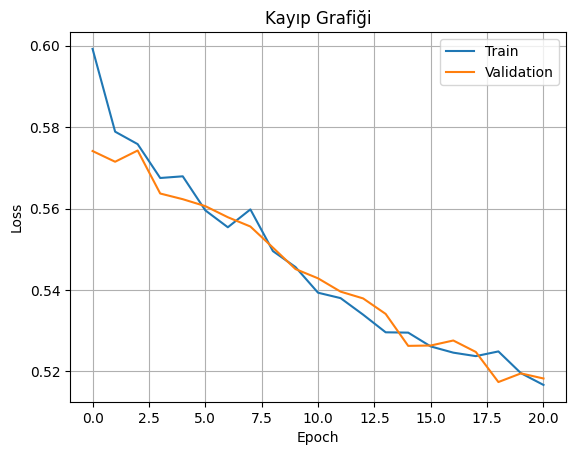

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Kayıp Grafiği")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

In [ ]:
def evaluate_model_metrics_light(model, data_loader, device, class_names, criterion=None):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    total_loss = 0.0
    total_samples = 0

    start_time = time.time()
    with torch.no_grad():
        for x_seq, x_static, team_ids, rakip_ids, labels in data_loader:
            x_seq = x_seq.to(device)
            x_static = x_static.to(device)
            team_ids = team_ids.to(device)
            rakip_ids = rakip_ids.to(device)
            labels = labels.to(device)

            outputs = model(x_seq, x_static, team_ids, rakip_ids)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # 🔹 Kayıp hesapla (opsiyonel olarak criterion verilmişse)
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item() * labels.size(0)
                total_samples += labels.size(0)

            y_true.append(labels.cpu())
            y_pred.append(preds.cpu())
            y_prob.append(probs.cpu())

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    y_prob = torch.cat(y_prob).numpy()
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))

    acc = accuracy_score(y_true, y_pred)

    try:
        auc_score = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')
    except:
        auc_score = None

    cm = confusion_matrix(y_true, y_pred)

    specificity_per_class = []
    for i in range(len(class_names)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_per_class.append(specificity)

    metrics = {
        "Test Loss": total_loss / total_samples if total_samples > 0 else None,
        "Accuracy": acc,
        #"Precision": prec,
        #"Recall (Sensitivity)": rec,
        #"F1 Score": f1,
        #"Specificity (avg)": np.mean(specificity_per_class),
        #"AUC": auc_score,
        "Inference Time (s)": time.time() - start_time
    }

    return metrics, cm


Test Loss: 0.6068
Accuracy: 0.2768
Inference Time (s): 0.4940

Karmaşıklık Matrisi:
[[ 61  91   3]
 [ 41  63   2]
 [ 57 211  31]]

Classification Report:
              precision    recall  f1-score   support

  Mağlubiyet       0.38      0.39      0.39       155
  Beraberlik       0.17      0.59      0.27       106
   Galibiyet       0.86      0.10      0.19       299

    accuracy                           0.28       560
   macro avg       0.47      0.36      0.28       560
weighted avg       0.60      0.28      0.26       560



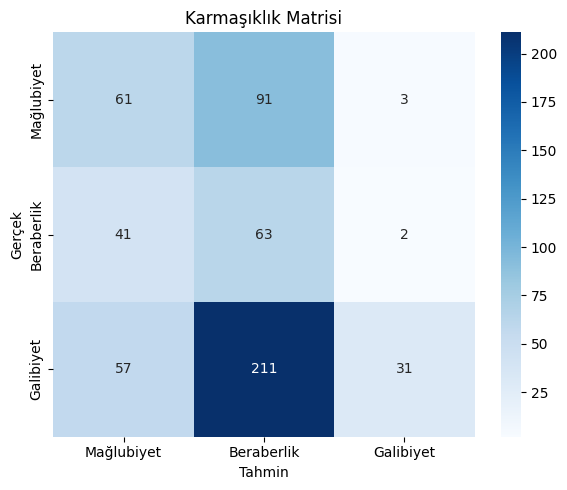

In [ ]:
class_names = ["Mağlubiyet", "Beraberlik", "Galibiyet"]
metrics, confusion = evaluate_model_metrics_light(model, test_loader, device, class_names, criterion=criterion)


print()
for key, val in metrics.items():
    print(f"{key}: {val:.4f}")

print("\nKarmaşıklık Matrisi:")
print(confusion)


model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for x_seq, x_static, team_ids, rakip_ids, labels in test_loader:
        x_seq = x_seq.to(device)
        x_static = x_static.to(device)
        team_ids = team_ids.to(device)
        rakip_ids = rakip_ids.to(device)
        labels = labels.to(device)

        outputs = model(x_seq, x_static, team_ids, rakip_ids)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Karmaşıklık matrisi çiz
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Mağlubiyet", "Beraberlik", "Galibiyet"],
            yticklabels=["Mağlubiyet", "Beraberlik", "Galibiyet"])
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Karmaşıklık Matrisi")
plt.tight_layout()
plt.show()

In [ ]:
def plot_multiclass_roc(y_true, y_prob, class_names):
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Mikro ortalama
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # ROC Eğrilerini çiz
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Eğrileri (Çok Sınıflı)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

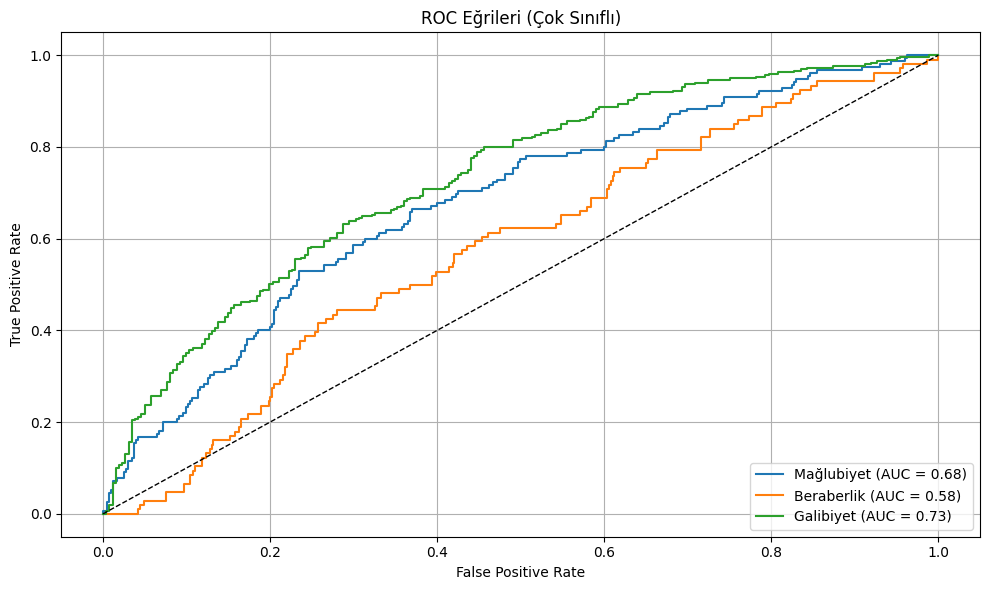

In [ ]:
model.eval()
y_true, y_prob = [], []

with torch.no_grad():
    for x_seq, x_static, team_ids, rakip_ids, labels in test_loader:
        x_seq, x_static = x_seq.to(device), x_static.to(device)
        team_ids, rakip_ids = team_ids.to(device), rakip_ids.to(device)

        outputs = model(x_seq, x_static, team_ids, rakip_ids)
        probs = torch.softmax(outputs, dim=1)

        y_true.append(labels.cpu())
        y_prob.append(probs.cpu())

y_true = torch.cat(y_true).numpy()
y_prob = torch.cat(y_prob).numpy()

plot_multiclass_roc(y_true, y_prob, class_names=["Mağlubiyet", "Beraberlik", "Galibiyet"])